In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable
import sys
sys.path.append("../src/models/")
from vae import Encoder
from vae import Decoder
from vae import reconstruction_loss_function
from vae import cell_reconstruction_loss_function

In [2]:
netEncoder = Encoder(input_size = 2, hidden_size = 10, latent_dim = 2)
netDecoder = Decoder(input_size = 2, hidden_size = 10, latent_dim = 2)

netEncoder.load_state_dict(torch.load("../src/models/weight/vae_encoder.pth"))
netDecoder.load_state_dict(torch.load("../src/models/weight/vae_decoder.pth"))

<All keys matched successfully>

In [3]:
X_test = torch.Tensor(np.load("../data/external/X_test.npy"))
y_test = torch.Tensor(np.load("../data/external/y_test.npy"))
input_size = 2

In [4]:
X_test.shape

torch.Size([200, 2])

In [5]:
# Reconstruction for test data
netEncoder.eval()
netDecoder.eval()
test_recon_loss = 0
cell_test_recon_loss = 0
test_recon_loss_list = []
cell_test_recon_loss_list = []
with torch.no_grad():
    for batch_idx, data in enumerate(X_test):
        recon_loss_m_list = []
        cell_recon_loss_m_list = []
        for _ in range(10):
            data = Variable(data)
            z, mu, log_var = netEncoder(data, input_size)
            recon_batch = netDecoder(z)
            test_recon_loss = reconstruction_loss_function(recon_batch, data, input_size).numpy()
            cell_test_recon_loss = cell_reconstruction_loss_function(recon_batch, data, input_size).numpy()  # add
            recon_loss_m_list = np.append(recon_loss_m_list, test_recon_loss)
            cell_recon_loss_m_list = np.append(cell_recon_loss_m_list, cell_test_recon_loss)

        test_recon_loss_list = np.append(test_recon_loss_list, np.mean(recon_loss_m_list))
        cell_recon_loss_m_list = cell_recon_loss_m_list.reshape(-1, input_size)
        cell_test_recon_loss_list = np.append(cell_test_recon_loss_list, np.mean(cell_recon_loss_m_list, axis=0))

In [6]:
# make grid
feature_1, feature_2 = np.meshgrid(
    np.linspace(X_test[:, 0].detach().numpy().min()-2, X_test[:, 0].detach().numpy().max()+2),
    np.linspace(X_test[:, 1].detach().numpy().min()-2, X_test[:, 1].detach().numpy().max()+2)
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

In [7]:
netEncoder.eval()
netDecoder.eval()
grid_recon_loss = 0
cell_grid_recon_loss = 0
grid_recon_loss_list = []
cell_grid_recon_loss_list = []
with torch.no_grad():
    for batch_idx, data in enumerate(torch.tensor(grid).float()):
        recon_loss_m_list = []
        cell_recon_loss_m_list = []
        for _ in range(10):
            data = Variable(data)
            z, mu, log_var = netEncoder(data, input_size)
            recon_batch = netDecoder(z)
            grid_recon_loss = reconstruction_loss_function(recon_batch, data, input_size).numpy()
            cell_grid_recon_loss = cell_reconstruction_loss_function(recon_batch, data, input_size).numpy()  # add
            recon_loss_m_list = np.append(recon_loss_m_list, grid_recon_loss)
            cell_recon_loss_m_list = np.append(cell_recon_loss_m_list, cell_grid_recon_loss)

        grid_recon_loss_list = np.append(grid_recon_loss_list, np.mean(recon_loss_m_list))
        cell_recon_loss_m_list = cell_recon_loss_m_list.reshape(-1, input_size)
        cell_grid_recon_loss_list = np.append(cell_grid_recon_loss_list, np.mean(cell_recon_loss_m_list, axis=0))

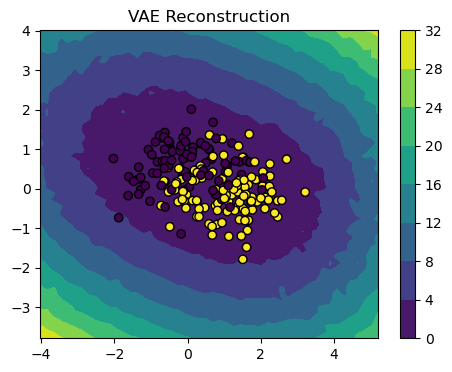

In [8]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.set_title("VAE Reconstruction")
c_ax1 = ax1.contourf(feature_1,feature_2,np.reshape(grid_recon_loss_list,feature_1.shape))
ax1.scatter(X_test[:,0].detach().numpy(),X_test[:,1].detach().numpy(),c=y_test,edgecolors="black")
fig.colorbar(c_ax1)